In [1]:
import sys
import os
import yaml
import tensorflow as tf
import pandas as pd
import numpy as np
import netCDF4 as nc
from os.path import exists, join
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D, StandardScaler2D, seed_everything
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
import pickle
from sklearn.utils import class_weight
from os import listdir
from os.path import isfile, join
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import matplotlib.pyplot as plt
from keras import backend as K
import scipy.io as scio
from scipy import stats
from echo.src.base_objective import BaseObjective
from echo.src.pruners import KerasPruningCallback
sys.path.append('/glade/work/fanda/optimization/echo_opt')
sys.path.append('/glade/work/fanda/util/goes16ci/goes16ci')
#from models_test import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D
import optuna
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

2023-05-19 08:30:27.792278: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.
2023-05-19 08:30:31.568854: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-05-19 08:30:31.570260: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-19 08:30:36.428111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-05-19 08:30:36.428150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-05-19 08:30:36.432318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-05-19 08:30:36.432405: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-05-19 08:30:36.434122: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.

In [72]:
int(np.shape(processed_file.variables['label'])[0]/2)

33

In [5]:
#def main():
seed_everything(3)
#seed_everything(4835)
My_dir = '/glade/scratch/fanda/files/GOESR_HRRR_PC'#GOESR_HRRR_PC/'
train_dir = My_dir+'/train_20/' 
test_dir = My_dir+'/test_21/'
onlyfiles = [f for f in listdir(train_dir) if isfile(join(train_dir, f))]
testfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]

config_file = open('/glade/work/fanda/optimization/benchmark_config_default_echo_best_resnet.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
print(config["dtype"])
# load data serial
logging.info("Split training and validation data")
train = []
label = []
test = []
test_label = []
lat_1 = []
lon_1 = []
date_1 = []
Type_1 = []
lat_train = []
lon_train = []
Type_train = []
benchmark_data = dict()
# load data serial
benchmark_data["config"] = config
for file in onlyfiles:
    processed_file = nc.Dataset(os.path.join(train_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    train.append(processed_file.variables['predictor'])
    label.append(processed_file.variables['label'])
    lat_1.append(processed_file.variables['lat_0'])
    lon_1.append(processed_file.variables['lon_0'])
    Type_1.append(processed_file.variables['Type'])
all_images = np.concatenate(train).astype(config["dtype"])
all_labels = np.concatenate(label).astype(config["dtype"])
lat_train = np.concatenate(lat_1).astype(config["dtype"])
lon_train = np.concatenate(lon_1).astype(config["dtype"])
Type_train = np.concatenate(Type_1).astype(config["dtype"])
all_images = np.moveaxis(all_images,1,-1)
delete_row =[]
for i in range(len(all_labels)):
    if np.sum(np.isnan(all_images[i,:,:,:]))>0 or np.max(all_images[i,:,:,:])>60000:
        delete_row.append(i)
    elif Type_train[i] > 1:
        if lon_train[i] > -91-0.5 or lon_train[i] < -104+0.5 \
        or lat_train[i] > 48-0.5 or lat_train[i] <34+0.5:
            delete_row.append(i)
lat_1 = []
lon_1 = []
Type_1 = []
all_images = np.delete(all_images, delete_row, 0)
all_labels = np.delete(all_labels, delete_row, 0)
delete_row =[]
for file in testfiles:
    processed_file = nc.Dataset(os.path.join(test_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    if file.endswith("RM.nc"):
        half_size=int(np.shape(processed_file.variables['label'])[0]/2)
        test.append(processed_file.variables['predictor'][:half_size,:,:,:])
        test_label.append(processed_file.variables['label'][:half_size])
        lat_1.append(processed_file.variables['lat_0'][:half_size])
        lon_1.append(processed_file.variables['lon_0'][:half_size])
        date_1.append(processed_file.variables['date'][:half_size])
        Type_1.append(processed_file.variables['Type'][:half_size])
    else:
        test.append(processed_file.variables['predictor'])
        test_label.append(processed_file.variables['label'])
        lat_1.append(processed_file.variables['lat_0'])
        lon_1.append(processed_file.variables['lon_0'])
        date_1.append(processed_file.variables['date'])
        Type_1.append(processed_file.variables['Type'])
test_images = np.concatenate(test).astype(config["dtype"])
test_labels = np.concatenate(test_label).astype(config["dtype"])
lat_0 = np.concatenate(lat_1).astype(config["dtype"])
lon_0 = np.concatenate(lon_1).astype(config["dtype"])
date_0 = np.concatenate(date_1).astype(config["dtype"])
Type_0 = np.concatenate(Type_1).astype(config["dtype"])
test_images = np.moveaxis(test_images,1,-1)
for i in range(len(test_labels)):
    if np.sum(np.isnan(test_images[i,:,:,:]))>0 or np.max(test_images[i,:,:,:])>60000:
        delete_row.append(i)
    elif Type_0[i] > 1:
        if lon_0[i] > -91-0.5 or lon_0[i] < -104+0.5 \
        or lat_0[i] > 48-0.5 or lat_0[i] <34+0.5:
            delete_row.append(i)
test_images = np.delete(test_images, delete_row, 0)
test_labels = np.delete(test_labels, delete_row, 0)
lat_0= np.delete(lat_0, delete_row, 0)
lon_0= np.delete(lon_0, delete_row, 0)
date_0= np.delete(date_0, delete_row, 0)
Type_0= np.delete(Type_0, delete_row, 0)
#print(np.shape(all_images))
#print(np.shape(test_images))
num = np.shape(all_images)[0]
shuffler = np.random.permutation(len(all_images))
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
lat_0 = lat_0[shuffler2]
lon_0 = lon_0[shuffler2]
date_0 = date_0[shuffler2]
Type_0 = Type_0[shuffler2]

train_val_split = int(num*0.7)#25000
num_ch = np.arange(14,21)#np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
#scaler = MinMaxScaler2D()
#train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
#val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
#test_data_scaled = 1.0 - scaler.transform(test_data)
scaler = StandardScaler2D()
train_data_scaled = scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)
print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))
#for i in range(num_ch):
#    for j in range(num):
#        all_images[j,:,:,i] = (all_images[j,:,:,i] - np.min(np.squeeze(all_images[j,:,:,i])))\
#        /(np.max(np.squeeze(all_images[j,:,:,i]))-np.min(np.squeeze(all_images[j,:,:,i])))
#train_val_split = 28000 #1300 #14000

float32
(45077, 32, 32, 7)
(19320, 32, 32, 7)
(30221, 32, 32, 7)


In [7]:
seed_everything(3)
shuffler = np.random.permutation(len(all_images))
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
train_val_split = int(num*0.7)#25000
num_ch = np.arange(14,21)#np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
#scaler = MinMaxScaler2D()
#train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
#val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
#test_data_scaled = 1.0 - scaler.transform(test_data)
scaler = StandardScaler2D()
train_data_scaled = scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)
print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

(45077, 32, 32, 7)
(19320, 32, 32, 7)
(30221, 32, 32, 7)


In [36]:
num_ch = np.arange(42,49)#np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
#scaler = MinMaxScaler2D()
#train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
#val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
#test_data_scaled = 1.0 - scaler.transform(test_data)
scaler = StandardScaler2D()
train_data_scaled = scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)
print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

(45077, 32, 32, 7)
(19320, 32, 32, 7)
(30221, 32, 32, 7)


In [41]:
np.sum(val_label)/val_label.shape

array([0.58178054])

In [42]:
np.sum(train_label)/train_label.shape

array([0.57801096])

In [44]:
np.sum(test_label)/test_label.shape

array([0.57817412])

In [71]:
import scipy.io as scio
scio.savemat('test_data/test_lead60.mat',{'test_data_scaled':test_data_scaled, 'test_label':test_label})

In [90]:
print(config["conv_net_parameters"]["dropout_alpha"])

0.23426761196590523


In [72]:
import pickle

# save
with open('scaler_lead_time/60min/std_scaler.bin','wb') as f:
    pickle.dump(scaler, f)


In [73]:
# load
with open('scaler_lead_time/60min/std_scaler.bin', 'rb') as f:
    test_scaler = pickle.load(f)

In [61]:
test = test_scaler.reverse_transform(test_data_scaled)
print(np.sum(test-test_data))

0.0


In [ ]:
        config_file = open('/glade/work/fanda/optimization/benchmark_config_default_echo_best_resnet.yml',"r")
        config = yaml.load(config_file, Loader=yaml.Loader)
        benchmark_data = dict()
        # load data serial
        benchmark_data["config"] = config
        benchmark_data["system"] = dict()
        benchmark_data["system"]["hostname"] = platform.node()
        benchmark_data["system"]["platform"] = platform.platform()
        benchmark_data["system"]["python_version"] = platform.python_version()
        benchmark_data["system"]["python_compiler"] = platform.python_compiler()
        benchmark_data["system"]["tensorflow_version"] = tf.__version__
        benchmark_data["system"]["gpus"] = get_gpu_names()
        has_gpus = True
        if len(benchmark_data["system"]["gpus"]) == 0:
            has_gpus = False
        #benchmark_data["system"].update(**get_cuda_version())
        benchmark_data["system"]["cudnn_version"] = get_cudnn_version()
        benchmark_data["system"]["nccl_version"] = get_nccl_version()
        benchmark_data["system"]["gpu_topology"] = get_gpu_topo()
        has_gpus = True
        out_path = '/glade/work/fanda/optimization'
        #print("Training Data==",train_data)
        parent_p, child_p = Pipe()
        dl_monitor = Monitor(child_p)
        monitor_proc = Process(target=dl_monitor.run)
        monitor_proc.start()
        batch_loss = None
        epoch_loss = None
        trial = None
        try:
            # CPU training
            if config["cpu"]:
                logging.info("CPU Training")
                block_name = "cpu_training"
                start_timing(benchmark_data, block_name, parent_p, out_path)
                epoch_times, batch_loss, epoch_loss = train_conv_net_cpu(train_data_scaled, train_label,
                                val_data_scaled, val_label, config["conv_net_parameters"],
                                                 config["num_cpus"], config["random_seed"],trial=trial)
                end_timing(benchmark_data, epoch_times, block_name, parent_p, out_path)
                benchmark_data[block_name]["batch_loss"] = batch_loss
                benchmark_data[block_name]["epoch_loss"] = epoch_loss
            # Build model (Single GPU Training)
            if config["single_gpu"] and has_gpus:
                #train_label_one_hot = tf.one_hot(train_label, 2).numpy()
                #test_label_one_hot = tf.one_hot(test_label, 2).numpy()
                logging.info("Single GPU Training")
                block_name = "gpu_{0:02d}_training".format(1)
                start_timing(benchmark_data, block_name, parent_p, out_path)
                epoch_times, batch_loss, epoch_loss, val_metric = train_conv_net_gpu(train_data_scaled, train_label,
                                val_data_scaled, val_label, config["conv_net_parameters"],
                                1, config["random_seed"], dtype=config["dtype"],trial=trial)#,monitor='val_loss')
                end_timing(benchmark_data, epoch_times, block_name, parent_p, out_path)
                benchmark_data[block_name]["batch_loss"] = batch_loss
                benchmark_data[block_name]["epoch_loss"] = epoch_loss

            # Save benchmark data
            parent_p.send("exit")
            monitor_proc.join()
            output_filename = str(join(config["out_path"], "goes_benchmark_data_{0}.yml".format(datetime.utcnow().strftime("%Y%m%d_%H%M%S"))))
            logging.info("Saving benchmark data to {output_filename}".format(output_filename=output_filename))
            with open(output_filename, "w") as output_file:
                yaml.dump(benchmark_data, output_file,Dumper=yaml.Dumper)
            #print_summary(benchmark_data)
        except Exception as e:
            logging.error(traceback.format_exc())
            parent_p.send("exit")
            monitor_proc.join()
            sys.exit()
        #results_dictionary = {
        #    "train_loss": batch_loss,
        #    "val_loss": epoch_loss,
        #}

        #results_dictionary = {
        #    self.metric: np.max(val_metric)#self.metric: np.min(epoch_loss) 
        #}
        print(val_metric)
        #return results_dictionary


Epoch 1/10
177/177 [==============================] - 23s 121ms/step - loss: 3.9008 - auc: 0.5815 - val_loss: 0.8218 - val_auc: 0.5410
{'loss': 1.9549843072891235, 'auc': 0.6196749806404114, 'val_loss': 0.821766197681427, 'val_auc': 0.5410284996032715}
Epoch 2/10
177/177 [==============================] - 26s 145ms/step - loss: 0.8433 - auc: 0.6889 - val_loss: 0.6469 - val_auc: 0.7096
{'loss': 0.8174733519554138, 'auc': 0.7050286531448364, 'val_loss': 0.6468896865844727, 'val_auc': 0.7095999717712402}
Epoch 3/10
177/177 [==============================] - 26s 146ms/step - loss: 0.8018 - auc: 0.7188 - val_loss: 0.5928 - val_auc: 0.7332
{'loss': 0.7795083522796631, 'auc': 0.7268586158752441, 'val_loss': 0.5928145051002502, 'val_auc': 0.733163058757782}
Epoch 4/10
177/177 [==============================] - 26s 146ms/step - loss: 0.7571 - auc: 0.7400 - val_loss: 0.5854 - val_auc: 0.7438
{'loss': 0.7477997541427612, 'auc': 0.7464855313301086, 'val_loss': 0.5854015350341797, 'val_auc': 0.7438

In [75]:
[0.54,0.48,0.45,0.5,0.48,0.5]

0.6971719861030579


In [37]:
import tensorflow as tf
my_model = tf.keras.models.load_model("/glade/work/fanda/echo_resnet_lead_time/60min/goes16_resnet_gpus_01.h5",compile=False)#,custom_objects={'loss_func_CE': loss_func_CE})
#my_model = tf.keras.models.load_model("goes16_resnet_gpus_01.h5",compile=False)
#my_model.summary()

In [38]:
CSI = np.zeros(21)
for i in np.arange(0.4,0.61,0.01):
    binary_threshold = i
    preds = my_model.predict(val_data_scaled).reshape(val_label.shape)
    binary_preds = np.where(preds >= binary_threshold, 1, 0)
    POD, POFD, FAR, SR, CSI[int((i-0.39)/0.01-1)], FB, ETS, HSS = scores(val_label, binary_preds)
    print('threshold: {}'.format(i))
    print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}, FB:{}'.format(POD, POFD, FAR, SR, CSI[int((i-0.39)/0.01-1)], FB))
print(np.where(CSI==max(CSI)))
print('best threshold: {}'.format(0.4+(np.where(CSI==max(CSI))[0])*0.01))

1525 6555 270 10970
threshold: 0.4
POD: 0.9759786476868327, POFD: 0.8112623762376238, FAR: 0.374037089871612, SR: 0.625962910128388, CSI:0.61646529924136, FB:1.5591637010676156
1558 6522 285 10955
threshold: 0.41000000000000003
POD: 0.974644128113879, POFD: 0.8071782178217822, FAR: 0.3731761744006408, SR: 0.6268238255993591, CSI:0.616766129940322, FB:1.5548932384341636
1601 6479 299 10941
threshold: 0.42000000000000004
POD: 0.9733985765124555, POFD: 0.8018564356435643, FAR: 0.3719288174512055, SR: 0.6280711825487945, CSI:0.6174727693436424, FB:1.5498220640569393
1632 6448 318 10922
threshold: 0.43000000000000005
POD: 0.9717081850533807, POFD: 0.7980198019801981, FAR: 0.3712147380541163, SR: 0.6287852619458837, CSI:0.6174807779285392, FB:1.545373665480427
1674 6406 341 10899
threshold: 0.44000000000000006
POD: 0.9696619217081851, POFD: 0.7928217821782179, FAR: 0.3701820283155157, SR: 0.6298179716844843, CSI:0.6176470588235294, FB:1.539590747330961
1727 6353 364 10876
threshold: 0.450000

In [78]:
from ai2es_xai_course.utils import utils
#my_model.summary()
binary_threshold = 0.48#0.54 0.48 0.45 0.5 0.48 0.5
preds_2 = my_model.predict(test_data_scaled)[:,0]
print(np.shape(preds_2))
#my_model.predict(test_data_scaled).reshape(test_label.shape)
binary_preds = np.where(preds_2 >= binary_threshold, 1, 0)
# Example regressed metrics
#cm = POD_score(test_label, binary_preds)
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_label, preds_2),3)))
print('R squared: {}'.format(np.round(r2_corr(test_label, preds_2),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_label, preds_2),3)))
POD, POFD, FAR, SR, CSI, FB, ETS, HSS = scores(test_label, binary_preds)
print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}'.format(POD, POFD, FAR, SR, CSI))
# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_label, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_label, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_label, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_label, preds_2),3)))
print('Accuracy score: {}'.format(np.round(accuracy_score(test_label, binary_preds),3)))
print('AUC: {}'.format(np.round(auc_score(test_label, preds_2),3)))

(30221,)
RMSE: 0.4790000021457672
R squared: 0.107
Hellenger Distance: 0.745
2542 10206 675 16798
POD: 0.9613689692668689, POFD: 0.8005961719485409, FAR: 0.3779440082950674, SR: 0.6220559917049326, CSI:0.6068860869251057
Heidke Skill Score: 0.179
[[ 2542 10206]
 [  675 16798]]
Pierce Skill Score: 0.161
Brier Score: 0.36
Brier Skill Score: 0.058
Accuracy score: 0.64
AUC: 0.677


In [39]:
for i in np.arange(0.3,0.4,0.01):
    binary_threshold = i
    preds = my_model.predict(val_data_scaled).reshape(val_label.shape)
    binary_preds = np.where(preds >= binary_threshold, 1, 0)
    POD, POFD, FAR, SR, CSI[int((i-0.3)/0.01)], FB, ETS, HSS = scores(val_label, binary_preds)
    print('threshold: {}'.format(i))
    print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}, FB:{}'.format(POD, POFD, FAR, SR, CSI[int((i-0.3)/0.01)], FB))

3356 4724 654 10586
threshold: 0.3
POD: 0.941814946619217, POFD: 0.5846534653465346, FAR: 0.3085564990202482, SR: 0.6914435009797518, CSI:0.6631170132798797, FB:1.3620996441281137
3388 4692 672 10568
threshold: 0.31
POD: 0.9402135231316726, POFD: 0.5806930693069307, FAR: 0.30747051114023594, SR: 0.6925294888597641, CSI:0.6633191062013558, FB:1.3576512455516014
3415 4665 689 10551
threshold: 0.32
POD: 0.9387010676156584, POFD: 0.5773514851485149, FAR: 0.30658517350157727, SR: 0.6934148264984227, CSI:0.6633762967620245, FB:1.3537366548042704
3452 4628 704 10536
threshold: 0.33
POD: 0.9373665480427046, POFD: 0.5727722772277227, FAR: 0.3051965180691111, SR: 0.6948034819308889, CSI:0.6639778169901689, FB:1.3491103202846975
3483 4597 728 10512
threshold: 0.34
POD: 0.9352313167259787, POFD: 0.5689356435643564, FAR: 0.30425574161096036, SR: 0.6957442583890396, CSI:0.6637620761507861, FB:1.344217081850534
3516 4564 755 10485
threshold: 0.35000000000000003
POD: 0.9328291814946619, POFD: 0.564851

In [40]:
print(np.where(CSI==max(CSI)))
print('best threshold: {}'.format(0.3+(np.where(CSI==max(CSI))[0])*0.01))

(array([3]),)
best threshold: [0.33]


In [102]:
print(np.sum(train_label)/np.shape(train_label))
print(np.sum(val_label)/np.shape(val_label))
print(np.sum(test_label)/np.shape(test_label))

[0.52968]
[0.53125307]
[0.52331606]


In [35]:
np.where(test_labels==0)[:3000]
#test_labels = np.delete(test_labels, delete_row, 0)

(array([  872,   873,   874, ..., 34844, 34845, 34846]),)

In [65]:
test_labels_new = np.delete(test_labels, np.array(np.where(test_labels==0)[0][:3000]), 0)
test_data_new = np.delete(test_data_scaled, np.array(np.where(test_labels==0)[0][:3000]), 0)

In [66]:
np.shape(test_data_new)

(31847, 32, 32, 7)

In [54]:
test_labels_new

masked_array(data=[1., 1., 1., ..., 1., 1., 1.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [59]:
np.array(np.where(test_labels==0)[0][:3000]).shape

(3000,)

In [41]:
print(delete_row)

[621, 5522, 5526, 5554, 5571, 6282, 6438, 6525, 6662, 6671, 6694, 6704, 6716, 6730, 13319, 13373, 13476, 13515, 13573, 13586, 14031, 14058, 14101, 17691, 17702, 17716, 21128, 21180, 21202, 23538, 23553, 23673, 23703, 24806, 24825, 25182, 25202, 25207, 25215, 25219, 25248, 25266, 25290, 25310, 27941, 33713]


In [21]:
print('best threshold: {}'.format(0.4+(np.where(CSI==max(CSI))[0]-1)*0.01))

best threshold: [0.49]


In [3]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score, accuracy_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def stat(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    C, F, M, H = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    return C, F, M, H

def scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    C, F, M, H = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    print(C, F, M, H)
    POD = H/(H+M)
    POFD = F/(F+C)
    FAR = F/(F+H)
    SR = H/(F+H)
    CSI = H/(H+F+M)
    FB = POD/(1-FAR)
    R = (H+M)*(H+F)/(H+C+M+F)
    ETS = (H-R)/(H+M+F-R)
    HSS = 2*(H*C-M*F)/((H+M)*(M+C)+(H+F)*(F+C))
    return POD, POFD, FAR, SR, CSI, FB, ETS, HSS

def scores_new(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    C, F, M, H = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    print(C, F, M, H)
    POD = H/(H+M)
    POFD = F/(F+C)
    FAR = F/(F+H)
    SR = H/(F+H)
    CSI = H/(H+F+M)
    return C, F, M, H, POD, POFD, FAR, SR, CSI

#tn, fp, fn, tp
def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2


import tensorflow as tf
my_model = tf.keras.models.load_model("/glade/work/fanda/echo_resnet_lead_time/10min/goes16_resnet_gpus_01.h5",compile=False)#,custom_objects={'loss_func_CE': loss_func_CE})
#my_model = tf.keras.models.load_model("goes16_resnet_gpus_01.h5",compile=False)
my_model.summary()

In [4]:
POD_all_log = np.zeros(6)
POFD_all_log = np.zeros(6)
FAR_all_log = np.zeros(6)
SR_all_log = np.zeros(6)
CSI_all_log = np.zeros(6)
ETS_all_log = np.zeros(6)
HSS_all_log = np.zeros(6)
AUC_all_log = np.zeros(6)
BSS_all_log = np.zeros(6)
CN_all_log = np.zeros(6)
FR_all_log = np.zeros(6)
MS_all_log = np.zeros(6)
HT_all_log = np.zeros(6)

In [6]:
import pickle
#T = [0.49,0.46,0.41,0.40,0.40,0.31]
T = [0.36, 0.37, 0.4, 0.37, 0.39, 0.4]
for i in range(6):
    with open('echo_log_lead_time/'+str((i+1))+'0min/Logistic_regression_optimal.pkl', 'rb') as f:
        log = pickle.load(f)
    load_data = scio.loadmat('test_data/test_lead'+str(10*(i+1))+'.mat')
    test_data_scaled_flatten = load_data["test_data_scaled"].reshape((-1,7168))
    log_preds = log.predict_proba(test_data_scaled_flatten)[:,1]
    binary_threshold = T[i]
    binary_preds = np.where(log_preds >= binary_threshold, 1, 0)
    POD_all_log[i], POFD_all_log[i], FAR_all_log[i], SR_all_log[i], CSI_all_log[i], _, ETS_all_log[i], HSS_all_log[i] = scores(load_data["test_label"][0,:], binary_preds)
    print(SR_all_log[i],POD_all_log[i])
    BSS_all_log[i] = np.round(brier_skill_score(load_data["test_label"][0,:], log_preds),3)
    AUC_all_log[i] = auc_score(load_data["test_label"][0,:], log_preds)
    CN_all_log[i], FR_all_log[i], MS_all_log[i], HT_all_log[i] = stat(load_data["test_label"][0,:], binary_preds)

5657 7091 1105 16368
0.6977279508930474 0.9367595719109483


In [7]:
POD_all = np.zeros(6)
POFD_all = np.zeros(6)
FAR_all = np.zeros(6)
SR_all = np.zeros(6)
CSI_all = np.zeros(6)
ETS_all = np.zeros(6)
HSS_all = np.zeros(6)
AUC_all = np.zeros(6)
BSS_all = np.zeros(6)
CN_all = np.zeros(6)
FR_all = np.zeros(6)
MS_all = np.zeros(6)
HT_all = np.zeros(6)

In [8]:
    test_data_scaled=load_data["test_data_scaled"]
    test_label=load_data["test_label"][0,:]
    binary_threshold = 0.49
    preds = my_model.predict(test_data_scaled).reshape(test_label.shape)
    binary_preds = np.where(preds >= binary_threshold, 1, 0)

2023-03-08 11:57:44.027909: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-08 11:57:44.061746: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2023-03-08 11:57:44.325450: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-03-08 11:57:44.964019: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-03-08 11:57:44.966467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


In [79]:
T = [0.54,0.48,0.45,0.5,0.48,0.5]

In [8]:
#T = [0.49,0.46,0.41,0.40,0.40,0.31]
#print out: C F M H
T = [0.54,0.48,0.45,0.5,0.48,0.5]
for i in range(1):
    my_model = tf.keras.models.load_model("/glade/work/fanda/echo_resnet_lead_time/"+str(10*(i+1))+"min/goes16_resnet_gpus_01.h5",compile=False)
    load_data = scio.loadmat('test_data/test_lead'+str(10*(i+1))+'.mat')
    binary_threshold = T[i]
    preds = my_model.predict(load_data["test_data_scaled"]).reshape(load_data["test_label"].shape)
    binary_preds = np.where(preds >= binary_threshold, 1, 0)
    POD_all[i], POFD_all[i], FAR_all[i], SR_all[i], CSI_all[i], _, ETS_all[i], HSS_all[i] = scores(load_data["test_label"][0,:], binary_preds[0,:])
    print(SR_all[i],POD_all[i])
    BSS_all[i] = np.round(brier_skill_score(load_data["test_label"][0,:], preds[0,:]),3)
    AUC_all[i] = auc_score(load_data["test_label"][0,:], preds[0,:])
    CN_all[i], FR_all[i], MS_all[i], HT_all[i] = stat(load_data["test_label"][0,:], binary_preds[0,:])

2023-04-05 13:08:00.168950: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 13:08:00.169546: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-05 13:08:00.170372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-04-05 13:08:00.170407: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-05 13:08:00.170460: I tensorflow/stream_executor/platform/default/dso_load

7703 5045 1184 16289
0.7635230149057842 0.9322383105362559


In [221]:
#from ai2es_xai_course.utils import utils
#my_model = utils.read_dense_net("goes16_resnet_gpus_01_echo.h5")
#my_model.summary()
# Evaluation using the same model
T = [0.49,0.46,0.41,0.40,0.40,0.31]
for i in range(6):
    load_data = scio.loadmat('test_data/test_lead'+str(10*(i+1))+'_allIR_new21.mat')
    binary_threshold = 0.49
    preds = my_model.predict(load_data["test_data_scaled"]).reshape(load_data["test_label"].shape)
    binary_preds = np.where(preds >= binary_threshold, 1, 0)
    POD_all[i], POFD_all[i], FAR_all[i], SR_all[i], CSI_all[i], _, ETS_all[i], HSS_all[i] = scores(load_data["test_label"][0,:], binary_preds[0,:])
    AUC_all[i] = auc_score(load_data["test_label"][0,:], preds[0,:])
    CN_all[i], FR_all[i], MS_all[i], HT_all[i] = stat(load_data["test_label"][0,:], binary_preds[0,:])

9415 6501 1284 16189
9197 6719 2768 14705
8953 6963 4212 13261
8632 7284 4915 12558
8391 7525 5429 12044
8227 7689 5651 11822


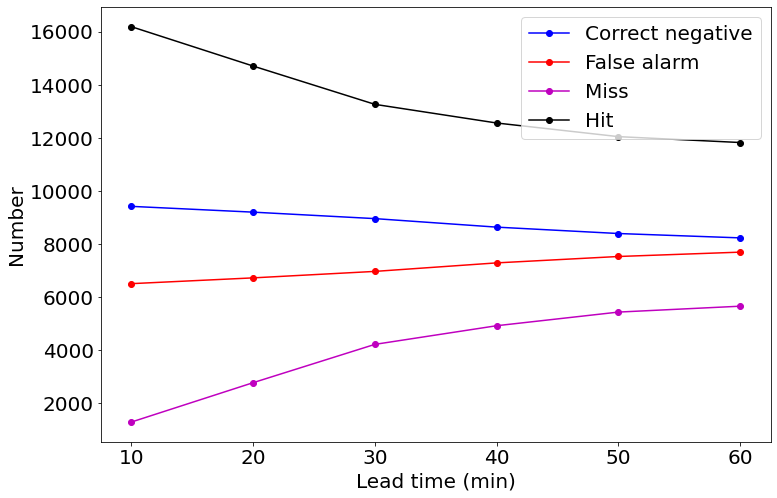

In [222]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(12, 8))
lead_time = np.arange(10,70,10)
plt.plot(lead_time, CN_all,'-bo')
plt.plot(lead_time, FR_all,'-ro')
plt.plot(lead_time, MS_all,'-mo')
plt.plot(lead_time, HT_all,'-ko')
plt.legend(['Correct negative','False alarm','Miss','Hit'], loc= "best") #,bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xticks(np.arange(10, 70, step=10))
plt.xlabel("Lead time (min)")
plt.ylabel("Number")
plt.show()

In [30]:
CSI_ref = 0.52331606

In [28]:
np.diff(CSI_fitted)

array([-0.04221691, -0.04006385, -0.03802059, -0.03608154, -0.03424138])

In [39]:
np.sum(load_data["test_label"][0,:])/load_data["test_label"][0,:].shape

array([0.57817412])

In [120]:
from scipy.optimize import curve_fit

# Fit the function a * np.exp(b * t) + c to x and y
x = lead_time
y = CSI_all
popt, pcov = popt, pcov = curve_fit(
    lambda t, a, b, c: a * np.exp(b * t) + c,
    x, y, p0=(0.222, -0.038, 0.526)
) 
#curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, x, y, p0=(0.593, -0.002, 0.53))

In [121]:
# The optimised values of the parameters are
a = popt[0]
b = popt[1]
c = popt[2]

print(a, b, c)

0.22162812453808245 -0.039835568948639585 0.5263090089782421


In [129]:
x = lead_time
y = CSI_all_log
popt, pcov = popt, pcov = curve_fit(
    lambda t, a, b, c: a * np.exp(b * t) + c,
    x, y, p0=(0.115, -0.054, 0.526)
) 

In [130]:
# The optimised values of the parameters are
a = popt[0]
b = popt[1]
c = popt[2]

print(a, b, c)

0.12481166753080485 -0.061716305343374175 0.5257689057333433


In [127]:
CSI_fitted=a * np.exp(b * x) + c
print(CSI_fitted)

[0.59310137 0.56209298 0.54536477 0.53634033 0.53147188 0.52884548]


In [128]:
print(r2_score(CSI_all_log, CSI_fitted))

0.9716676202385124


In [ ]:
[a,b]=np.polyfit(lead_time, np.log(CSI_all_log), 1)
print(a,np.exp(b))
CSI_fitted_log =  np.exp(b) * np.exp(a * lead_time)
print(r2_score(CSI_all_log, CSI_fitted_log))

[0.20357009 0.03528411 0.578     ]
[0.1368758  0.04385358 0.578     ]


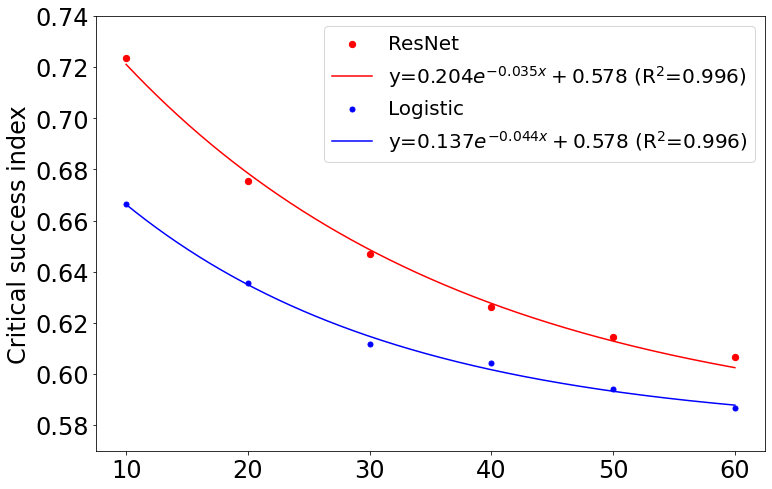

In [32]:
import matplotlib
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

# Fit the function a * np.exp(b * t) + c to x and y
x = lead_time
y = CSI_all
x0 = np.arange(10,60.001,0.001)
popt, pcov = popt, pcov = curve_fit(
    lambda t, a, b, c: a * np.exp(-b * t) + c,
    x, y, p0=(0.18,0.03,0.578),
    bounds=(0, [3., 1., 0.578])#x, y, p0=(0.18950647737689474,-0.032577736758608346, 0.578)#(0.222, -0.038, 0.5)
) 

CSI_fitted =  popt[0] * np.exp(-popt[1] * x0)+popt[2]
#print(r2_score(CSI_all, CSI_fitted))
print(popt)

x = lead_time
y = CSI_all_log
popt, pcov = popt, pcov = curve_fit(
    lambda t, a, b, c: a * np.exp(-b * t) + c,
    x, y, p0=(0.115, 0.054, 0.578),
    bounds=(0, [3., 1., 0.578])
) 
CSI_log_fitted =  popt[0] * np.exp(-popt[1] * x0) + popt[2]
#print(r2_score(CSI_all_log, CSI_log_fitted))
print(popt)

matplotlib.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(12, 8))
lead_time = np.arange(10,70,10)
plt.scatter(lead_time, CSI_all, s=40, c='r')
plt.plot(x0, CSI_fitted,'r')
plt.scatter(lead_time, CSI_all_log, s=25, c='b')
plt.plot(x0, CSI_log_fitted,'b')
plt.legend(['ResNet','y=0.204$e^{-0.035x}+0.578$ (R$^{2}$=0.996)','Logistic','y=0.137$e^{-0.044x}+0.578$ (R$^{2}$=0.996)',]
           , loc='best',fontsize='20')#, bbox_to_anchor=(0.9,0.37,0.05,0.15), fontsize='16')#bbox_to_anchor=(1.04, 1), loc="upper left", fontsize='20')
plt.xticks(np.arange(10, 70, step=10))
plt.ylim([0.57, 0.74])
#plt.xlabel("Lead time (min)")
plt.ylabel("Critical success index")
#plt.show()
plt.savefig('plots/CSI_lead_time.png')

[ 0.55834592 -0.03544089 -0.00802638]
[ 0.3404748  -0.05352522  0.03806708]


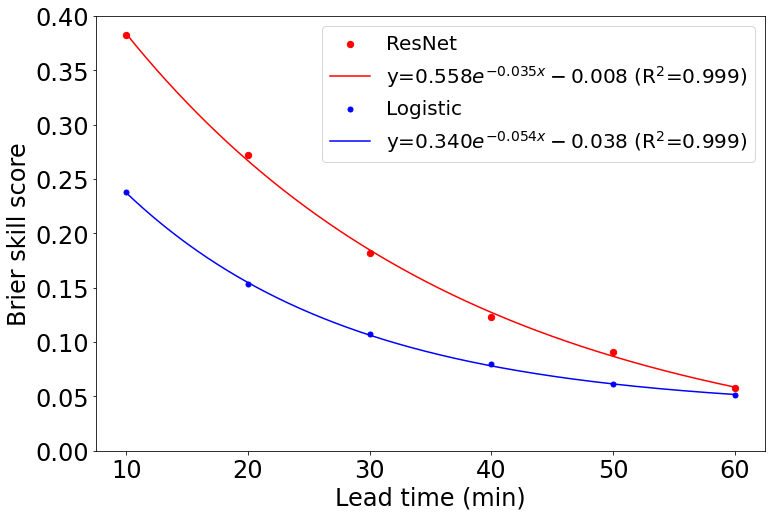

In [26]:
import matplotlib
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

# Fit the function a * np.exp(b * t) + c to x and y
lead_time = np.arange(10,61,10)
x = lead_time
y = BSS_all
x0 = np.arange(10,60.001,0.001)
popt, pcov = popt, pcov = curve_fit(
    lambda t, a, b, c: a * np.exp(b * t) + c,
    x, y, p0=(0.222, -0.038, 0.526)
) 
BSS_all_fitted =  popt[0] * np.exp(popt[1] * x0) + popt[2]
#BSS_all_fitted_tested =  popt[0] * np.exp(popt[1] * lead_time) + popt[2]
#print(r2_score(BSS_all, BSS_all_fitted_tested))
print(popt)

x = lead_time
y = BSS_all_log
popt, pcov = popt, pcov = curve_fit(
    lambda t, a, b, c: a * np.exp(b * t) + c,
    x, y, p0=(0.115, -0.054, 0.526)
) 
BSS_all_log_fitted =  popt[0] * np.exp(popt[1] * x0) + popt[2]
#print(r2_score(BSS_all_log, BSS_all_log_fitted))
print(popt)

matplotlib.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(12, 8))
lead_time = np.arange(10,70,10)
plt.scatter(lead_time, BSS_all, s=40, c='r')
plt.plot(x0, BSS_all_fitted,'r')
plt.scatter(lead_time, BSS_all_log, s=25, c='b')
plt.plot(x0, BSS_all_log_fitted,'b')
plt.legend(['ResNet','y=0.558$e^{-0.035x}-0.008$ (R$^{2}$=0.999)','Logistic','y=0.340$e^{-0.054x}-0.038$ (R$^{2}$=0.999)',]
           , loc='best',fontsize='20')#, bbox_to_anchor=(0.9,0.37,0.05,0.15), fontsize='16')#bbox_to_anchor=(1.04, 1), loc="upper left", fontsize='20')
plt.xticks(np.arange(10, 70, step=10))
plt.ylim([0.0, 0.4])
plt.xlabel("Lead time (min)")
plt.ylabel("Brier skill score")
#plt.show()
plt.savefig('plots/BSS_lead_time.png')

-0.0034148175916180333 0.7298972304747676
0.9218845104990916
-0.032577736758608346 0.18950647737689474
0.9901804179386124
-0.0024306857003870883 0.6705870872159857
0.9184829305454937
-0.04455733081778898 0.1396213309259196
0.9953066915961523


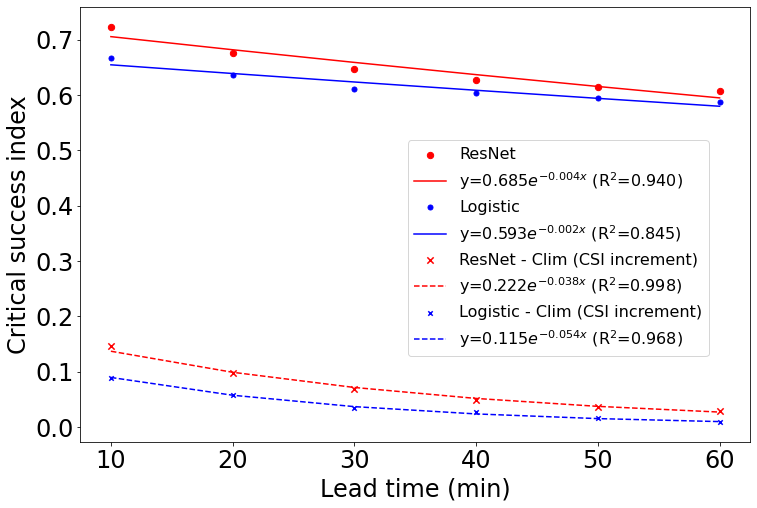

In [45]:
import matplotlib
from sklearn.metrics import r2_score
CSI_ref = 0.578 #0.52331606
#r2_score(y, predict(x))
[a,b]=np.polyfit(lead_time, np.log(CSI_all), 1)
print(a,np.exp(b))
CSI_fitted =  np.exp(b) * np.exp(a * lead_time)
print(r2_score(CSI_all, CSI_fitted))
#CSI_fitted = a * np.exp(b * x) + c

[a,b]=np.polyfit(lead_time, np.log(CSI_all-CSI_ref), 1)
print(a,np.exp(b))
CSI_inc_fitted =  np.exp(b) * np.exp(a * lead_time)
print(r2_score(CSI_all-CSI_ref, CSI_inc_fitted))

[a,b]=np.polyfit(lead_time, np.log(CSI_all_log), 1)
print(a,np.exp(b))
CSI_fitted_log =  np.exp(b) * np.exp(a * lead_time)
print(r2_score(CSI_all_log, CSI_fitted_log))

[a,b]=np.polyfit(lead_time, np.log(CSI_all_log-CSI_ref), 1)
print(a,np.exp(b))
CSI_inc_fitted_log =  np.exp(b) * np.exp(a * lead_time)
print(r2_score(CSI_all_log-CSI_ref, np.exp(b) * np.exp(a * lead_time)))

matplotlib.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(12, 8))
lead_time = np.arange(10,70,10)
plt.scatter(lead_time, CSI_all, s=40, c='r')
plt.plot(lead_time, CSI_fitted,'r')
plt.scatter(lead_time, CSI_all_log, s=25, c='b')
plt.plot(lead_time, CSI_fitted_log,'b')
plt.scatter(lead_time, CSI_all-CSI_ref, s=40, c='r',marker='x')
plt.plot(lead_time, CSI_inc_fitted,'r--')
plt.scatter(lead_time, CSI_all_log-CSI_ref, s=20, c='b',marker='x')
plt.plot(lead_time, CSI_inc_fitted_log,'b--')
plt.legend(['ResNet','y=0.685$e^{-0.004x}$ (R$^{2}$=0.940)','Logistic','y=0.593$e^{-0.002x}$ (R$^{2}$=0.845)','ResNet - Clim (CSI increment)', 'y=0.222$e^{-0.038x}$ (R$^{2}$=0.998)','Logistic - Clim (CSI increment)','y=0.115$e^{-0.054x}$ (R$^{2}$=0.968)']
           , loc='best', bbox_to_anchor=(0.9,0.37,0.05,0.15), fontsize='16')#bbox_to_anchor=(1.04, 1), loc="upper left", fontsize='20')
plt.xticks(np.arange(10, 70, step=10))
plt.xlabel("Lead time (min)")
plt.ylabel("Critical success index")
plt.show()

-0.004140974237155566 0.6858008099976808
0.9403031395001998
-0.03811986600899483 0.22185341961139662
0.9982593460268214
-0.036135807856966816 0.5101723703469109
0.999159194509238
-0.002181121695823905 0.5926376534919242
0.8450706300105181
-0.05421403194772201 0.11472821786281531
0.9682421189427961
-0.032102572194893056 0.271382003251576
0.9717871879413972


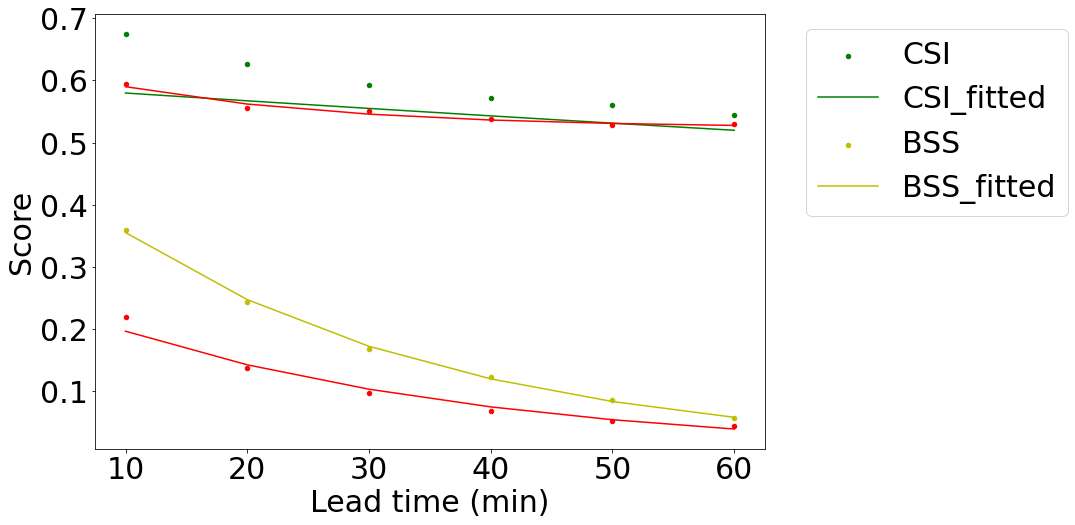

In [52]:
import matplotlib
from sklearn.metrics import r2_score
CSI_ref = 0.52331606
#r2_score(y, predict(x))
[a,b]=np.polyfit(lead_time, np.log(CSI_all), 1)
print(a,np.exp(b))
CSI_fitted =  np.exp(b) * np.exp(a * lead_time)
print(r2_score(CSI_all, CSI_fitted))

[a,b]=np.polyfit(lead_time, np.log(CSI_all-CSI_ref), 1)
print(a,np.exp(b))
CSI_fitted =  np.exp(b) * np.exp(a * lead_time) + CSI_ref
print(r2_score(CSI_all-CSI_ref, np.exp(b) * np.exp(a * lead_time)))
[a,b]=np.polyfit(lead_time, np.log(BSS_all), 1)
print(a,np.exp(b))
BSS_fitted = np.exp(b) * np.exp(a * lead_time)
print(r2_score(BSS_all, BSS_fitted))

[a,b]=np.polyfit(lead_time, np.log(CSI_all_log), 1)
print(a,np.exp(b))
CSI_fitted =  np.exp(b) * np.exp(a * lead_time)
print(r2_score(CSI_all_log, CSI_fitted))

[a,b]=np.polyfit(lead_time, np.log(CSI_all_log-CSI_ref), 1)
print(a,np.exp(b))
CSI_fitted_log =  np.exp(b) * np.exp(a * lead_time) + CSI_ref
print(r2_score(CSI_all_log-CSI_ref, np.exp(b) * np.exp(a * lead_time)))
[a,b]=np.polyfit(lead_time, np.log(BSS_all_log), 1)
print(a,np.exp(b))
BSS_fitted_log = np.exp(b) * np.exp(a * lead_time)
print(r2_score(BSS_all_log, BSS_fitted_log))

matplotlib.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(12, 8))
lead_time = np.arange(10,70,10)
plt.scatter(lead_time, CSI_all, s=20, c='g')
plt.plot(lead_time, CSI_fitted,'g')
plt.scatter(lead_time, BSS_all, s=20, c='y')
plt.plot(lead_time, BSS_fitted,'y')
plt.scatter(lead_time, CSI_all_log, s=20, c='r')
plt.plot(lead_time, CSI_fitted_log,'r')
plt.scatter(lead_time, BSS_all_log, s=20, c='r')
plt.plot(lead_time, BSS_fitted_log,'r')
plt.legend(['CSI','CSI_fitted','BSS','BSS_fitted'],bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xticks(np.arange(10, 70, step=10))
plt.xlabel("Lead time (min)")
plt.ylabel("Score")
plt.show()

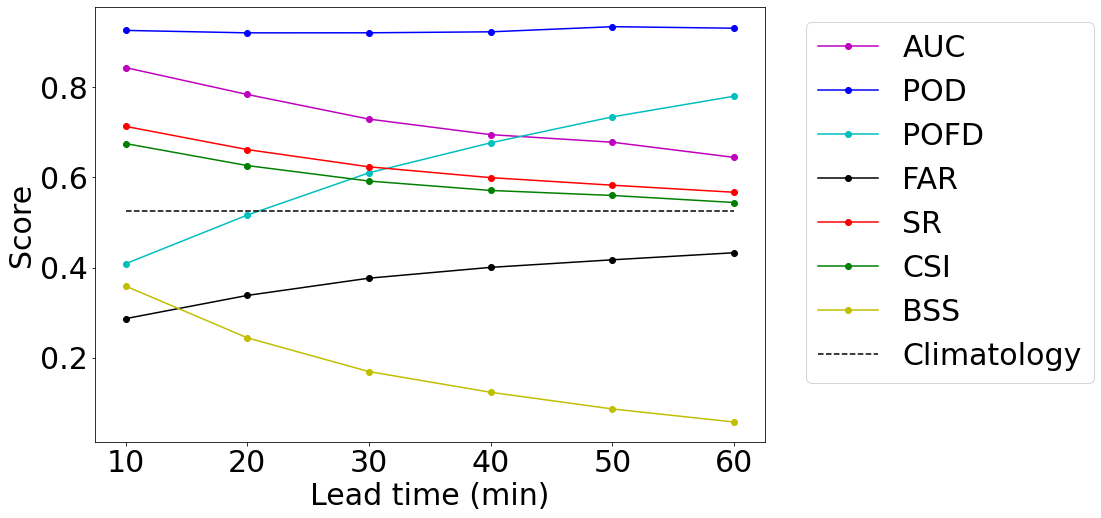

In [8]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(12, 8))
lead_time = np.arange(10,70,10)
plt.plot(lead_time, AUC_all,'-mo')
plt.plot(lead_time, POD_all,'-bo')
plt.plot(lead_time, POFD_all,'-co')
plt.plot(lead_time, FAR_all,'-ko')
plt.plot(lead_time, SR_all,'-ro')
plt.plot(lead_time, CSI_all,'-go')
plt.plot(lead_time, BSS_all,'-yo')
plt.plot(lead_time, np.ones(6)*0.52476904,'k--')
plt.legend(['AUC','POD','POFD','FAR','SR','CSI','BSS','Climatology'],bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xticks(np.arange(10, 70, step=10))
plt.xlabel("Lead time (min)")
plt.ylabel("Score")
plt.show()

In [197]:
scores(load_data["test_label"][0,:], binary_preds[0,:])

9415 6501 1284 16189


(0.9265151948720883,
 0.4084568987182709,
 0.2865138827677391,
 0.7134861172322609,
 0.6752732126470343,
 1.2985749441996224,
 0.35660936619489125,
 0.5257362584708273)

In [9]:
# Example regressed metrics
#cm = POD_score(test_label, binary_preds)
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_label, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(test_label, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_label, preds),3)))
POD, POFD, FAR, SR, CSI, FB, ETS, HSS = scores(test_label, binary_preds)
print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}, ETS:{}, HSS:{}'.format(POD, POFD, FAR, SR, CSI, ETS, HSS))
#print('POD: {}, FAR: {}, CSI: {}, ETS: {}, HSS: {}'.format(POD, POFD, FAR, SR, CSI))
# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_label, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_label, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_label, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_label, preds),3)))
print('Accuracy score: {}'.format(np.round(accuracy_score(test_label, binary_preds),3)))
print('AUC: {}'.format(np.round(auc_score(test_label, preds),3)))

RMSE: 0.4000000059604645
R squared: 0.376
Hellenger Distance: 0.529
9415 6501 1284 16189
POD: 0.9265151948720883, POFD: 0.4084568987182709, FAR: 0.2865138827677391, SR: 0.7134861172322609, CSI:0.6752732126470343, ETS:0.35660936619489125, HSS:0.5257362584708273
Heidke Skill Score: 0.526
[[ 9415  6501]
 [ 1284 16189]]
Pierce Skill Score: 0.518
Brier Score: 0.233
Brier Skill Score: 0.359
Accuracy score: 0.767
AUC: 0.844


In [167]:
lead_time = 10 min
T: 0.49 POD: 0.9265151948720883, POFD: 0.4084568987182709, FAR: 0.2865138827677391, SR: 0.7134861172322609, CSI:0.6752732126470343, ETS:0.35660936619489125, HSS:0.5257362584708273 AUC:0.844
lead_time = 20 min
T: 0.46 POD: 0.9210782349911292, POFD: 0.5164614224679568, FAR: 0.3380768281648433, SR: 0.6619231718351567, CSI:0.6263962947106215, ETS:0.259855735137543, HSS:0.41251665232793283 AUC: 0.784
lead_time = 30 min
T: 0.41 POD: 0.9211926973044126, POFD: 0.6103920583061071, FAR: 0.3763899112781372, SR: 0.6236100887218627, CSI:0.5920258937766661, ETS:0.18922212884315961, HSS:0.3182284020012803 AUC: 0.730
lead_time = 40 min
T: 0.40 POD: 0.9233674812567962, POFD: 0.6769917064589093, FAR: 0.40042365007989894, SR: 0.5995763499201011, CSI:0.5711554800339848, ETS:0.14485919266437586, HSS:0.25306027779233176 AUC: 0.695
lead_time = 50 min
T: 0.40 POD: 0.9347564814284897, POFD: 0.734606685096758, FAR: 0.41719892952720783, SR: 0.5828010704727922, CSI:0.5600205726041488, ETS:0.11497755796334942, HSS:0.20624192324260016 AUC: 0.678
lead_time = 60 min
T: 0.31 OD: 0.9313798431866308, POFD: 0.7804724805227444, FAR: 0.43288263172567604, SR: 0.5671173682743239, CSI:0.5443719685566148, ETS:0.08448237974061094, HSS:0.15580221738746478 AUC: 0.645
exponential?

SyntaxError: invalid syntax (2886773374.py, line 1)

In [206]:
POD_all = [0.9265151948720883, 0.9210782349911292, 0.9211926973044126, 0.9233674812567962, 0.9347564814284897, 0.9313798431866308]
POFD_all = [0.4084568987182709, 0.5164614224679568, 0.6103920583061071, 0.6769917064589093, 0.734606685096758, 0.7804724805227444]
FAR_all = [0.2865138827677391, 0.3380768281648433, 0.3763899112781372, 0.40042365007989894, 0.41719892952720783, 0.43288263172567604]
SR_all = [0.7134861172322609, 0.6619231718351567, 0.6236100887218627, 0.5995763499201011, 0.5828010704727922, 0.5671173682743239]
CSI_all = [0.6752732126470343, 0.6263962947106215, 0.5920258937766661, 0.5711554800339848, 0.5600205726041488, 0.5443719685566148]
ETS_all = [0.35660936619489125, 0.259855735137543, 0.18922212884315961, 0.14485919266437586, 0.11497755796334942, 0.08448237974061094]
HSS_all = [0.5257362584708273, 0.41251665232793283, 0.3182284020012803, 0.25306027779233176, 0.20624192324260016, 0.15580221738746478]
AUC_all = [0.844, 0.784, 0.730, 0.695, 0.678, 0.645]

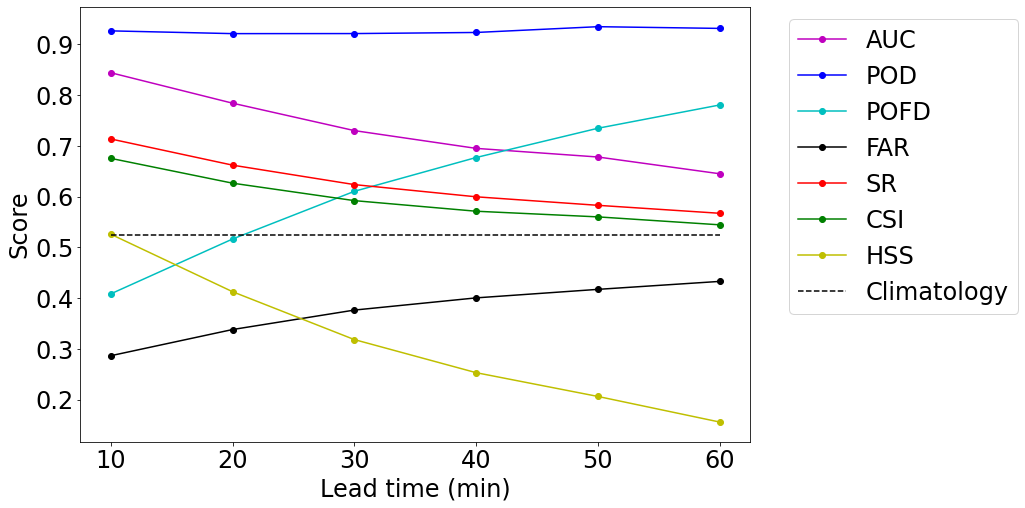

In [207]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(12, 8))
lead_time = np.arange(10,70,10)
plt.plot(lead_time, AUC_all,'-mo')
plt.plot(lead_time, POD_all,'-bo')
plt.plot(lead_time, POFD_all,'-co')
plt.plot(lead_time, FAR_all,'-ko')
plt.plot(lead_time, SR_all,'-ro')
plt.plot(lead_time, CSI_all,'-go')
plt.plot(lead_time, HSS_all,'-yo')
plt.plot(lead_time, np.ones(6)*0.52476904,'k--')
plt.legend(['AUC','POD','POFD','FAR','SR','CSI','HSS','Climatology'],bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xticks(np.arange(10, 70, step=10))
plt.xlabel("Lead time (min)")
plt.ylabel("Score")
plt.show()